In [1]:
import pandas as pd
import numpy as np  
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
import os 
from datetime import datetime
import mappings as mp

In [2]:
parquet_name = 'data/yellow_taxi_jan_2021.parquet'
csv_name = 'data/ny_taxi_location_lookup.csv'
data_url="https://d37ci6vzurychx.cloutaxi_df_cleanront.net/trip-data/yellow_tripdata_2021-01.parquet"
lookup_url="https://d37ci6vzurychx.cloutaxi_df_cleanront.net/misc/taxi+_zone_lookup.csv"

In [3]:
# ONE TIME DOWNLOAD  
# os.system(f'wget -O {parquet_name} {data_url}')
# os.system(f'wget -O {csv_name} {lookup_url}')

In [4]:
# READ IN DATA 
taxi_df_orig = pd.read_parquet(parquet_name)


In [5]:
# CHECK MEMORY USAGE 
memory_usage = taxi_df_orig.memory_usage(deep=True).sum() / (1024 ** 2)  # Convert to megabytes
print(f"Memory usage of DataFrame: {memory_usage:.2f} MB")

Memory usage of DataFrame: 260.69 MB


# MAPPINGS

In [6]:
# IMPORT MAPPING DICTIONARY
mapping = mp.mapping_dict
print(f'data type:{type(mapping)}', f'an example value: {mapping["payment_type"][3]}')
#dir(mappings)

data type:<class 'dict'> an example value: No charge


# BASIC INFO AND STATS

In [7]:
taxi_df = taxi_df_orig.copy()
taxi_df.columns = taxi_df.columns.str.lower()
columns = taxi_df.columns
columns 

Index(['vendorid', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'ratecodeid', 'store_and_fwd_flag',
       'pulocationid', 'dolocationid', 'payment_type', 'fare_amount', 'extra',
       'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge',
       'total_amount', 'congestion_surcharge', 'airport_fee'],
      dtype='object')

In [8]:
taxi_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1369769 entries, 0 to 1369768
Data columns (total 19 columns):
 #   Column                 Non-Null Count    Dtype         
---  ------                 --------------    -----         
 0   vendorid               1369769 non-null  int64         
 1   tpep_pickup_datetime   1369769 non-null  datetime64[us]
 2   tpep_dropoff_datetime  1369769 non-null  datetime64[us]
 3   passenger_count        1271417 non-null  float64       
 4   trip_distance          1369769 non-null  float64       
 5   ratecodeid             1271417 non-null  float64       
 6   store_and_fwd_flag     1271417 non-null  object        
 7   pulocationid           1369769 non-null  int64         
 8   dolocationid           1369769 non-null  int64         
 9   payment_type           1369769 non-null  int64         
 10  fare_amount            1369769 non-null  float64       
 11  extra                  1369769 non-null  float64       
 12  mta_tax                13697

#### REPLACE STORE AND FORWARD FLAG WITH A NUMERIC VALUE FOR ANALYSIS PURPOSES

In [9]:
print(taxi_df['store_and_fwd_flag'].unique())  
# Replace "Y" with 1 and "N" with 2 
taxi_df['store_and_fwd_flag'] = taxi_df['store_and_fwd_flag'].replace({"Y": 1, "N": 2}).astype(float) 
print(taxi_df['store_and_fwd_flag'].unique())

['N' 'Y' None]
[ 2.  1. nan]


#### LOOK AT NA, NULL, AND ZERO COUNTS

In [10]:
def nan_null_zero_datatypes(df):
    have_values = [(df[col].notna() & (df[col] != 0)).sum() for col in df.columns]
    nans = [df[col].isna().sum() for col in df.columns]
    blanks = [(df[col] == ' ').sum() for col in df.columns]
    zeros = [(df[col] == 0).sum() for col in df.columns]
    data_types = [df[col].apply(lambda x: type(x)).unique() for col in df.columns]
    len_data_types = [len(df[col].apply(lambda x: type(x)).unique()) for col in df.columns] 
    

    df_clean_check = pd.DataFrame({
        'Column Name': df.columns,
        'have_values': have_values,
        '# NAs': nans,
        '# Blanks': blanks,
        '# Zeros': zeros,
        '# Data Types': len_data_types,
        'Data Types': data_types
    })

    return df_clean_check

In [11]:
taxi_df_info = nan_null_zero_datatypes(taxi_df)
taxi_df_info

,Column Name,have_values,# NAs,# Blanks,# Zeros,# Data Types,Data Types
0,vendorid,1369769,0,0,0,1,[<class 'int'>]
1,tpep_pickup_datetime,1369769,0,0,0,1,[<class 'pandas._libs.tslibs.timestamps.Timest...
2,tpep_dropoff_datetime,1369769,0,0,0,1,[<class 'pandas._libs.tslibs.timestamps.Timest...
3,passenger_count,1244691,98352,0,26726,1,[<class 'float'>]
4,trip_distance,1349817,0,0,19952,1,[<class 'float'>]
5,ratecodeid,1271417,98352,0,0,1,[<class 'float'>]
6,store_and_fwd_flag,1271417,98352,0,0,1,[<class 'float'>]
7,pulocationid,1369769,0,0,0,1,[<class 'int'>]
8,dolocationid,1369769,0,0,0,1,[<class 'int'>]
9,payment_type,1271417,0,0,98352,1,[<class 'int'>]


## BASIC STATS

In [12]:
taxi_df.describe().round(2)

,vendorid,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,ratecodeid,store_and_fwd_flag,pulocationid,dolocationid,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
count,1369769.00,1369769,1369769,1271417.00,1369769.00,1271417.00,1271417.00,1369769.00,1369769.00,1369769.00,1369769.00,1369769.00,1369769.00,1369769.00,1369769.00,1369769.00,1369769.00,1271417.00,5.0
mean,1.72,2021-01-17 01:48:30.539849,2021-01-17 02:02:25.240572,1.41,4.63,1.04,1.99,165.25,161.50,1.19,12.10,0.97,0.49,1.92,0.25,0.30,17.47,2.24,0.0
min,1.00,2008-12-31 23:05:14,2008-12-31 23:07:22,0.00,0.00,1.00,1.00,1.00,1.00,0.00,-490.00,-5.50,-0.50,-100.00,-31.12,-0.30,-492.80,-2.50,0.0
25%,1.00,2021-01-09 13:42:49,2021-01-09 13:55:05,1.00,1.00,1.00,2.00,124.00,107.00,1.00,6.00,0.00,0.50,0.00,0.00,0.30,10.80,2.50,0.0
50%,2.00,2021-01-16 20:10:32,2021-01-16 20:24:06,1.00,1.70,1.00,2.00,162.00,162.00,1.00,8.50,0.00,0.50,1.86,0.00,0.30,13.80,2.50,0.0
75%,2.00,2021-01-24 15:32:45,2021-01-24 15:44:59,1.00,3.02,1.00,2.00,236.00,236.00,1.00,13.50,2.50,0.50,2.75,0.00,0.30,19.12,2.50,0.0
max,6.00,2021-02-22 16:52:16,2021-02-22 16:56:15,8.00,263163.28,99.00,2.00,265.00,265.00,4.00,6960.50,8.25,0.50,1140.44,811.75,0.30,7661.28,3.00,0.0
std,0.59,NaN,NaN,1.06,393.90,0.60,0.12,67.84,72.11,0.58,12.91,1.23,0.08,2.60,1.67,0.04,14.69,0.80,0.0


#### UNDERSTANDING THE DISCRETE VALUE COLUMNS

In [13]:
# PRINT UNIQUE VALUES FOR COLUMNS WITH DISCRETE VALUES
print("Value counts for columns with discrete values:")
for col in taxi_df.columns:
    unique_values = taxi_df[col].unique()
    if len(unique_values) < 20:
        print(f"{col}:")
        for value in unique_values:
            count = (taxi_df[col] == value).sum()
            print(f"    {value}: {count}")
            
        # OR FOLLOWING THE FIRST PRINT
        #value_counts = taxi_df[col].value_counts()
        #for value, count in value_counts.items():
        #    print(f"    {value}: {count}")

Value counts for columns with discrete values:
vendorid:
    1: 422337
    2: 937141
    6: 10291
passenger_count:
    1.0: 966236
    0.0: 26726
    2.0: 161671
    3.0: 43935
    5.0: 31089
    4.0: 16391
    6.0: 25362
    8.0: 2
    7.0: 5
    nan: 0
ratecodeid:
    1.0: 1249243
    2.0: 14858
    4.0: 1202
    5.0: 5212
    3.0: 856
    99.0: 36
    6.0: 10
    nan: 0
store_and_fwd_flag:
    2.0: 1252433
    1.0: 18984
    nan: 0
payment_type:
    2: 322891
    1: 934475
    4: 5667
    3: 8384
    0: 98352
mta_tax:
    0.5: 1357263
    0.0: 5948
    -0.5: 6558
improvement_surcharge:
    0.3: 1362457
    0.0: 658
    -0.3: 6654
congestion_surcharge:
    2.5: 1144198
    0.0: 121721
    -2.5: 5495
    0.75: 2
    3.0: 1
    nan: 0
airport_fee:
    nan: 0
    0.0: 5


## ADD NEW COLUMNS 
Adding now because duration will be used to select some records for removal. 

- duration_minute
- holiday flag 
- math check --> Total Amount - Fare and all Fees/ Charges

EVENTUALLY WANT TO ADD 
- Weather - temp and percipitation (rain/snow) flag
- Daytime - flag Y if between sunrise and sunset for that day

In [14]:
# BREAK OUT DROP OFF DATE INTO SEPARATE COLUMNS
taxi_df['drop_off_day'] = taxi_df['tpep_dropoff_datetime'].dt.day
taxi_df['drop_off_hour'] = taxi_df['tpep_dropoff_datetime'].dt.hour
taxi_df['drop_off_dow'] = taxi_df['tpep_dropoff_datetime'].dt.dayofweek

# ADD PICK UP DATE INTO SEPARATE COLUMNS
taxi_df['pick_up_day'] = taxi_df['tpep_pickup_datetime'].dt.day
taxi_df['pick_up_hour'] = taxi_df['tpep_pickup_datetime'].dt.hour
taxi_df['pick_up_dow'] = taxi_df['tpep_pickup_datetime'].dt.dayofweek

# ADD DURATION IN MINUTES COLUMN
taxi_df['duration_minute'] = (
    (taxi_df['tpep_dropoff_datetime'] - taxi_df['tpep_pickup_datetime'])
    .apply(lambda x: round(x.total_seconds() / 60))
    .astype(int)
)

taxi_df.head()

,vendorid,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,ratecodeid,store_and_fwd_flag,pulocationid,dolocationid,payment_type,...,total_amount,congestion_surcharge,airport_fee,drop_off_day,drop_off_hour,drop_off_dow,pick_up_day,pick_up_hour,pick_up_dow,duration_minute
0,1,2021-01-01 00:30:10,2021-01-01 00:36:12,1.0,2.10,1.0,2.0,142,43,2,...,11.80,2.5,NaN,1,0,4,1,0,4,6
1,1,2021-01-01 00:51:20,2021-01-01 00:52:19,1.0,0.20,1.0,2.0,238,151,2,...,4.30,0.0,NaN,1,0,4,1,0,4,1
2,1,2021-01-01 00:43:30,2021-01-01 01:11:06,1.0,14.70,1.0,2.0,132,165,1,...,51.95,0.0,NaN,1,1,4,1,0,4,28
3,1,2021-01-01 00:15:48,2021-01-01 00:31:01,0.0,10.60,1.0,2.0,138,132,1,...,36.35,0.0,NaN,1,0,4,1,0,4,15
4,2,2021-01-01 00:31:49,2021-01-01 00:48:21,1.0,4.94,1.0,2.0,68,33,1,...,24.36,2.5,NaN,1,0,4,1,0,4,17


In [15]:
# ADD HOLIDAY FLAG COLUMN

# List of US holidays in Jan 2021 
holidays = ['2021-01-01', '2021-01-18'] 

# Add a holiday flag column
taxi_df['is_holiday'] = (
    taxi_df['tpep_dropoff_datetime']
    .apply(lambda x: x.strftime('%Y-%m-%d') in holidays)
)

# Look at records with holidays
holiday = taxi_df[taxi_df['is_holiday'] == True]
print(f"Records with holidays: {holiday.shape[0]}")
holiday.tail()

Records with holidays: 61799


,vendorid,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,ratecodeid,store_and_fwd_flag,pulocationid,dolocationid,payment_type,...,congestion_surcharge,airport_fee,drop_off_day,drop_off_hour,drop_off_dow,pick_up_day,pick_up_hour,pick_up_dow,duration_minute,is_holiday
1327476,2,2021-01-18 23:10:53,2021-01-18 23:17:15,NaN,0.55,NaN,NaN,75,75,0,...,NaN,NaN,18,23,0,18,23,0,6,True
1327477,2,2021-01-18 23:02:59,2021-01-18 23:32:29,NaN,7.33,NaN,NaN,65,76,0,...,NaN,NaN,18,23,0,18,23,0,30,True
1327478,2,2021-01-18 23:17:00,2021-01-18 23:36:00,NaN,10.94,NaN,NaN,134,80,0,...,NaN,NaN,18,23,0,18,23,0,19,True
1327482,2,2021-01-18 23:19:00,2021-01-18 23:33:00,NaN,6.54,NaN,NaN,76,215,0,...,NaN,NaN,18,23,0,18,23,0,14,True
1327483,2,2021-01-18 23:17:00,2021-01-18 23:35:43,NaN,4.88,NaN,NaN,9,196,0,...,NaN,NaN,18,23,0,18,23,0,19,True


In [16]:
# CHECK IF THE AMOUNTS ADD UP

money_cols = ['payment_type', 'fare_amount', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge', 'congestion_surcharge', 'total_amount', 'math_check']

taxi_df['math_check'] = (
    taxi_df['total_amount'] -
    taxi_df['extra'] -
    taxi_df['mta_tax'] -
    taxi_df['tip_amount'] -
    taxi_df['tolls_amount'] -
    taxi_df['improvement_surcharge'] -
    taxi_df['congestion_surcharge'] -
    taxi_df['fare_amount']
).round(2)


math_check_df = taxi_df[taxi_df['math_check'] != 0]
print(math_check_df.shape[0])

464658


# QUESTIONABLE DATA 
### Look into these further

- **airport_fee** -- only 5 records with 0 and rest nan --> drop this columns
- **negatives** 
- **NaNs** -- - 98352 records with NA in passenger_count, rate_code_id, store_and_fwd_flag, and congestion_surcharge and 0 in Payment type<br> --> account for **.07%** of the records
- **trip distance** -- 19952 records with trip_distance = 0 
- **vendor_id** -- 10291 records with vendor_id = 6
- **passengers** -- 26726 records with 0 passengers
- **ratecodeid** -- 36 records with ratecodeid = 99 
- **total amount** 452 records with 0 total amount
- negative amounts - check to see if all negative taxes correspond to negative amounts -- guessing they are refunds

### DROP AIRPORT FEE COLUMN

In [17]:
# DROP THE AIRPORT FEE COLUMN
taxi_df = taxi_df.drop('airport_fee', axis=1)
taxi_df.shape 

(1369769, 27)

### NEGATIVE AMOUNTS
First suspected that these were refunds but the records have non negative trip distances. 
The rows with neg fare amount will be dropped. That captures all but few rows with other neg values. 

In [18]:
# LOOK AT COUNTS OF NEGATIVE VALUES
print('COUNTS OF NEGATIVE VALUES PER COLUMN')
for col in taxi_df.columns:
    if taxi_df[col].dtype != 'datetime64[us]':
        negatives = (taxi_df[col] < 0).sum()
        if negatives > 0: 
            print(f"    {col}: {negatives}")

COUNTS OF NEGATIVE VALUES PER COLUMN
    fare_amount: 6769
    extra: 2292
    mta_tax: 6558
    tip_amount: 59
    tolls_amount: 139
    improvement_surcharge: 6654
    total_amount: 6662
    congestion_surcharge: 5495
    duration_minute: 2509
    math_check: 365789


In [19]:
# CONFIRM THAT ALMOST ALL OF THE NEGATIVE TAXES, CHARGES ETC OCCUR WITH THE NEGATIVE FARES
neg_fare = taxi_df[taxi_df['fare_amount'] < 0]
for col in neg_fare.columns:
    if neg_fare[col].dtype != 'datetime64[us]':
        negatives = (neg_fare[col] < 0).sum()
        if negatives > 0: 
            print(f"    {col}: {negatives}")

    fare_amount: 6769
    extra: 2290
    mta_tax: 6554
    tip_amount: 57
    tolls_amount: 139
    improvement_surcharge: 6654
    total_amount: 6662
    congestion_surcharge: 5495
    math_check: 2


In [20]:
# STATS FOR NEGATIVE FARES DATAFRAME
neg_fare.describe().round(2)

,vendorid,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,ratecodeid,store_and_fwd_flag,pulocationid,dolocationid,payment_type,...,total_amount,congestion_surcharge,drop_off_day,drop_off_hour,drop_off_dow,pick_up_day,pick_up_hour,pick_up_dow,duration_minute,math_check
count,6769.00,6769,6769,6655.00,6769.00,6655.00,6655.0,6769.00,6769.00,6769.00,...,6769.00,6655.00,6769.00,6769.00,6769.00,6769.00,6769.00,6769.00,6769.00,6655.00
mean,2.00,2021-01-16 19:27:53.208155,2021-01-16 19:37:04.878711,1.36,1.84,1.12,2.0,161.17,160.31,3.31,...,-13.41,-2.06,16.22,13.73,3.02,16.22,13.69,3.02,9.18,-0.00
min,2.00,2021-01-01 00:11:01,2021-01-01 00:13:56,1.00,0.00,1.00,2.0,3.00,1.00,0.00,...,-492.80,-2.50,1.00,0.00,0.00,1.00,0.00,0.00,0.00,-5.00
25%,2.00,2021-01-08 18:42:26,2021-01-08 18:59:18,1.00,0.20,1.00,2.0,107.00,100.00,3.00,...,-13.80,-2.50,8.00,11.00,1.00,8.00,11.00,1.00,2.00,0.00
50%,2.00,2021-01-16 15:59:37,2021-01-16 16:00:59,1.00,0.74,1.00,2.0,161.00,162.00,4.00,...,-8.80,-2.50,16.00,14.00,3.00,16.00,14.00,3.00,4.00,0.00
75%,2.00,2021-01-24 15:49:18,2021-01-24 16:12:02,1.00,1.81,1.00,2.0,234.00,234.00,4.00,...,-6.80,-2.50,24.00,17.00,5.00,24.00,17.00,5.00,10.00,0.00
max,6.00,2021-01-31 23:45:23,2021-01-31 23:45:28,6.00,34.35,5.00,2.0,265.00,265.00,4.00,...,29.00,0.00,31.00,23.00,6.00,31.00,23.00,6.00,1437.00,-0.00
std,0.08,NaN,NaN,0.92,3.33,0.58,0.0,68.08,72.23,0.85,...,16.32,0.95,8.85,5.12,1.90,8.85,5.08,1.90,49.62,0.09


In [21]:
nan_neg_fare = neg_fare.isna().sum()
print(nan_neg_fare)

vendorid                   0
tpep_pickup_datetime       0
tpep_dropoff_datetime      0
passenger_count          114
trip_distance              0
ratecodeid               114
store_and_fwd_flag       114
pulocationid               0
dolocationid               0
payment_type               0
fare_amount                0
extra                      0
mta_tax                    0
tip_amount                 0
tolls_amount               0
improvement_surcharge      0
total_amount               0
congestion_surcharge     114
drop_off_day               0
drop_off_hour              0
drop_off_dow               0
pick_up_day                0
pick_up_hour               0
pick_up_dow                0
duration_minute            0
is_holiday                 0
math_check               114
dtype: int64


### CHECK NaN RECORDS 
All NaNs are in the same rows. These rows will be dropped. 

In [22]:
# CHECK IF ALL NaNs ARE IN THE SAME ROWS
na_check = taxi_df[taxi_df['passenger_count'].isna()]
print(f"Rows with NAs: {na_check.shape[0]} ")
na_check.describe().round(2)    

Rows with NAs: 98352 


,vendorid,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,ratecodeid,store_and_fwd_flag,pulocationid,dolocationid,payment_type,...,total_amount,congestion_surcharge,drop_off_day,drop_off_hour,drop_off_dow,pick_up_day,pick_up_hour,pick_up_dow,duration_minute,math_check
count,98352.0,98352,98352,0.0,98352.00,0.0,0.0,98352.00,98352.00,98352.0,...,98352.00,0.0,98352.00,98352.00,98352.00,98352.00,98352.00,98352.00,98352.00,0.0
mean,2.3,2021-01-16 17:40:36.754270,2021-01-16 18:02:16.080466,NaN,29.67,NaN,NaN,151.42,135.55,0.0,...,31.03,NaN,16.19,13.03,2.80,16.19,12.75,2.80,21.66,NaN
min,1.0,2021-01-01 00:01:04,2021-01-01 00:01:02,NaN,0.00,NaN,NaN,1.00,1.00,0.0,...,-64.30,NaN,1.00,0.00,0.00,1.00,0.00,0.00,-1.00,NaN
25%,2.0,2021-01-08 20:56:55.250000,2021-01-08 21:14:09.250000,NaN,2.10,NaN,NaN,75.00,71.00,0.0,...,19.71,NaN,8.00,10.00,1.00,8.00,9.00,1.00,10.00,NaN
50%,2.0,2021-01-15 22:27:00,2021-01-15 22:45:27,NaN,4.74,NaN,NaN,151.00,137.00,0.0,...,27.30,NaN,15.00,13.00,3.00,15.00,13.00,3.00,18.00,NaN
75%,2.0,2021-01-24 12:00:23.250000,2021-01-24 12:09:41.250000,NaN,9.69,NaN,NaN,233.00,210.00,0.0,...,39.50,NaN,24.00,16.00,4.00,24.00,16.00,4.00,30.00,NaN
max,6.0,2021-01-31 23:56:00,2021-02-01 00:38:00,NaN,263163.28,NaN,NaN,265.00,265.00,0.0,...,159.36,NaN,31.00,23.00,6.00,31.00,23.00,6.00,1680.00,NaN
std,1.3,NaN,NaN,NaN,1423.81,NaN,NaN,81.80,76.15,0.0,...,15.37,NaN,8.59,4.60,1.87,8.59,4.57,1.87,17.27,NaN


In [23]:
na_check[na_check['trip_distance'] == 0].shape

(1195, 27)

### RECORDS WITH TRIP DISTANCE = 0 
These records will be kept but will be excluded from any distance stats. 

In [24]:
# RECORDS WITH 0 TRIP DISTANCE
zero_distance = taxi_df[taxi_df['trip_distance'] == 0]
print(f"Records with 0 trip distance: {zero_distance.shape[0]} ")
zero_distance.describe().round(2)

Records with 0 trip distance: 19952 


,vendorid,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,ratecodeid,store_and_fwd_flag,pulocationid,dolocationid,payment_type,...,total_amount,congestion_surcharge,drop_off_day,drop_off_hour,drop_off_dow,pick_up_day,pick_up_hour,pick_up_dow,duration_minute,math_check
count,19952.00,19952,19952,18757.00,19952.0,18757.00,18757.00,19952.00,19952.00,19952.00,...,19952.00,18757.00,19952.00,19952.00,19952.00,19952.00,19952.00,19952.00,19952.00,18757.00
mean,1.31,2021-01-16 04:21:24.583700,2021-01-16 04:35:58.715617,1.13,0.0,1.78,1.95,148.87,152.73,1.34,...,22.77,0.45,15.82,13.69,2.86,15.82,13.59,2.85,14.52,-0.24
min,1.00,2008-12-31 23:05:14,2008-12-31 23:07:22,0.00,0.0,1.00,1.00,1.00,1.00,0.00,...,-492.80,-2.50,1.00,0.00,0.00,1.00,0.00,0.00,-4.00,-5.00
25%,1.00,2021-01-08 17:55:49,2021-01-08 18:19:07.250000,1.00,0.0,1.00,2.00,80.00,78.00,1.00,...,6.80,0.00,8.00,11.00,1.00,8.00,11.00,1.00,0.00,0.00
50%,1.00,2021-01-15 14:07:15,2021-01-15 14:22:00,1.00,0.0,1.00,2.00,145.00,151.00,1.00,...,18.00,0.00,15.00,14.00,3.00,15.00,14.00,3.00,6.00,0.00
75%,2.00,2021-01-23 15:27:39,2021-01-23 15:38:12,1.00,0.0,1.00,2.00,224.00,231.00,2.00,...,30.00,0.00,23.00,17.00,4.00,23.00,17.00,4.00,23.00,0.00
max,2.00,2021-01-31 23:49:23,2021-02-01 00:22:26,8.00,0.0,99.00,2.00,265.00,265.00,4.00,...,900.35,3.00,31.00,23.00,6.00,31.00,23.00,6.00,4419.00,5.00
std,0.46,NaN,NaN,0.67,0.0,3.56,0.21,73.96,78.65,0.78,...,29.34,1.06,8.55,5.10,1.89,8.55,5.03,1.89,46.87,0.75


### RECORDS WITH INVALID VENDOR ID (6) 
These all occur with the NaN combo. They will be dropped with the NaN drop. 

In [25]:
# RECORDS WITH VENDOR ID = 6
vendor_6 = taxi_df[taxi_df['vendorid'] == 6]
print(f"Records with vendor id = 6: {vendor_6.shape[0]} ")
vendor_6.describe().round(2)

Records with vendor id = 6: 10291 


,vendorid,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,ratecodeid,store_and_fwd_flag,pulocationid,dolocationid,payment_type,...,total_amount,congestion_surcharge,drop_off_day,drop_off_hour,drop_off_dow,pick_up_day,pick_up_hour,pick_up_dow,duration_minute,math_check
count,10291.0,10291,10291,0.0,10291.00,0.0,0.0,10291.0,10291.00,10291.0,...,10291.00,0.0,10291.00,10291.00,10291.00,10291.00,10291.00,10291.00,10291.00,0.0
mean,6.0,2021-01-16 01:46:30.566417,2021-01-16 02:08:51.288893,NaN,7.17,NaN,NaN,265.0,125.06,0.0,...,28.61,NaN,15.54,12.99,3.14,15.54,12.74,3.14,22.35,NaN
min,6.0,2021-01-01 00:01:04,2021-01-01 00:01:02,NaN,0.09,NaN,NaN,265.0,3.00,0.0,...,0.80,NaN,1.00,0.00,0.00,1.00,0.00,0.00,-1.00,NaN
25%,6.0,2021-01-08 13:01:58,2021-01-08 14:01:03,NaN,2.85,NaN,NaN,265.0,62.00,0.0,...,17.11,NaN,8.00,10.00,1.00,8.00,9.00,1.50,0.00,NaN
50%,6.0,2021-01-15 08:01:37,2021-01-15 09:01:01,NaN,5.82,NaN,NaN,265.0,117.00,0.0,...,26.76,NaN,15.00,13.00,3.00,15.00,13.00,3.00,0.00,NaN
75%,6.0,2021-01-23 13:01:09.500000,2021-01-23 13:01:03,NaN,10.36,NaN,NaN,265.0,190.00,0.0,...,35.23,NaN,23.00,16.00,5.00,23.00,16.00,5.00,59.00,NaN
max,6.0,2021-01-31 23:01:55,2021-02-01 00:02:03,NaN,32.62,NaN,NaN,265.0,265.00,0.0,...,99.37,NaN,31.00,23.00,6.00,31.00,23.00,6.00,1680.00,NaN
std,0.0,NaN,NaN,NaN,5.38,NaN,NaN,0.0,74.30,0.0,...,12.59,NaN,8.72,4.60,1.94,8.72,4.55,1.94,34.54,NaN


### RECORDS WITH NO PASSENGERS
This could be a data entry error. These records will be kept but excluded from per passenger stats

In [26]:
# RECORDS WITH 0 PASSANGERS
zero_passangers = taxi_df[taxi_df['passenger_count'] == 0]
print(f"Records with 0 passengers: {zero_passangers.shape[0]} ")
zero_passangers.describe().round(2)

Records with 0 passengers: 26726 


,vendorid,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,ratecodeid,store_and_fwd_flag,pulocationid,dolocationid,payment_type,...,total_amount,congestion_surcharge,drop_off_day,drop_off_hour,drop_off_dow,pick_up_day,pick_up_hour,pick_up_dow,duration_minute,math_check
count,26726.00,26726,26726,26726.0,26726.00,26726.00,26726.00,26726.00,26726.00,26726.00,...,26726.00,26726.00,26726.00,26726.00,26726.00,26726.00,26726.00,26726.00,26726.00,26726.00
mean,1.00,2021-01-17 00:48:41.100090,2021-01-17 00:59:19.589014,0.0,2.54,1.09,1.95,166.09,163.96,1.32,...,16.41,2.26,16.44,13.91,2.93,16.44,13.77,2.93,10.64,-2.26
min,1.00,2021-01-01 00:01:13,2021-01-01 00:14:01,0.0,0.00,1.00,1.00,1.00,1.00,1.00,...,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,-2.50
25%,1.00,2021-01-09 14:09:11.250000,2021-01-09 14:18:55.500000,0.0,0.90,1.00,2.00,132.00,107.00,1.00,...,10.35,2.50,9.00,11.00,1.00,9.00,11.00,1.00,5.00,-2.50
50%,1.00,2021-01-16 16:33:28.500000,2021-01-16 16:42:43.500000,0.0,1.50,1.00,2.00,162.00,162.00,1.00,...,13.30,2.50,16.00,14.00,3.00,16.00,14.00,3.00,8.00,-2.50
75%,1.00,2021-01-24 13:50:11.500000,2021-01-24 14:01:36.250000,0.0,2.70,1.00,2.00,236.00,236.00,2.00,...,17.75,2.50,24.00,17.00,4.00,24.00,17.00,4.00,14.00,-2.50
max,2.00,2021-01-31 23:48:50,2021-02-01 00:29:22,0.0,326.10,99.00,2.00,265.00,265.00,4.00,...,1155.65,2.50,31.00,23.00,6.00,31.00,23.00,6.00,520.00,0.00
std,0.06,NaN,NaN,0.0,3.84,2.19,0.21,65.03,70.88,0.55,...,14.93,0.74,8.57,4.39,1.88,8.57,4.35,1.88,8.94,0.74


In [27]:
# ONlY 5 RECORDS WITH 0 PASSENGERS AND ZERO FARE
zero_passangers[zero_passangers['total_amount'] == 0].shape

(5, 27)

### RECORDS WITH INVALID RATECODEID 
There are only 36 records. These will be deleted since there are not that many and it will make analysis easier later. 
Could try and figure out how the rate code is determined and see if the cost per time or distance matches the other rate codes... but that is too much work for 36 records. 

In [28]:
# RECORDS WITH RATECODEID = 99
ratecodeid_99 = taxi_df[taxi_df['ratecodeid'] == 99]
print(f"Records with ratecodeid = 99: {ratecodeid_99.shape[0]} ")
ratecodeid_99.describe().round(2)

Records with ratecodeid = 99: 36 


,vendorid,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,ratecodeid,store_and_fwd_flag,pulocationid,dolocationid,payment_type,...,total_amount,congestion_surcharge,drop_off_day,drop_off_hour,drop_off_dow,pick_up_day,pick_up_hour,pick_up_dow,duration_minute,math_check
count,36.00,36,36,36.00,36.00,36.0,36.00,36.00,36.00,36.00,...,36.00,36.00,36.00,36.00,36.00,36.00,36.00,36.00,36.00,36.0
mean,1.50,2021-01-18 14:27:31.805555,2021-01-18 14:56:38,0.72,1.19,99.0,1.86,194.92,205.00,1.86,...,48.56,0.97,17.97,15.17,3.08,17.94,15.28,3.06,29.08,0.0
min,1.00,2021-01-01 07:55:52,2021-01-01 08:04:02,0.00,0.00,99.0,1.00,15.00,13.00,1.00,...,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.0
25%,1.00,2021-01-13 05:58:12.500000,2021-01-13 05:58:20,0.00,0.00,99.0,2.00,135.75,142.50,1.75,...,6.80,0.00,12.75,11.00,2.00,12.75,11.00,2.00,0.00,0.0
50%,1.50,2021-01-20 20:32:09,2021-01-21 03:12:55,1.00,0.00,99.0,2.00,232.50,261.00,2.00,...,17.30,0.00,20.50,15.50,3.00,20.00,16.50,3.00,0.00,0.0
75%,2.00,2021-01-22 14:03:25.500000,2021-01-22 14:03:25.500000,1.00,0.80,99.0,2.00,264.00,264.00,2.00,...,35.48,2.50,22.00,19.25,4.00,22.00,20.00,4.00,6.50,0.0
max,2.00,2021-01-31 09:56:31,2021-01-31 10:09:01,2.00,18.17,99.0,2.00,264.00,264.00,3.00,...,831.00,2.50,31.00,23.00,6.00,31.00,23.00,6.00,895.00,0.0
std,0.51,NaN,NaN,0.61,3.20,0.0,0.35,76.34,79.13,0.59,...,136.99,1.24,7.71,4.99,1.56,7.70,5.12,1.57,148.66,0.0


In [29]:
# ONlY 6 RECORDS WITH INVALID RATECODEID AND ZERO FARE
ratecodeid_99[ratecodeid_99['total_amount'] == 0].shape

(6, 27)

In [30]:
nan_ratecodeid_99 = ratecodeid_99.isna().sum()
print(nan_ratecodeid_99)

vendorid                 0
tpep_pickup_datetime     0
tpep_dropoff_datetime    0
passenger_count          0
trip_distance            0
ratecodeid               0
store_and_fwd_flag       0
pulocationid             0
dolocationid             0
payment_type             0
fare_amount              0
extra                    0
mta_tax                  0
tip_amount               0
tolls_amount             0
improvement_surcharge    0
total_amount             0
congestion_surcharge     0
drop_off_day             0
drop_off_hour            0
drop_off_dow             0
pick_up_day              0
pick_up_hour             0
pick_up_dow              0
duration_minute          0
is_holiday               0
math_check               0
dtype: int64


### CHECK DATES AND EXCLUDE RECORDS WITH DROP OF DATE OUTSIDE OF JANUARY
Since the rate code is selected at drop off, I am assuming that the fare is also associated with the drop off. Records will be kept as long as the drop off time is in the month of Jan. 

In [31]:
# CHECK IF RECORDS OUTSIDE OF JAN 2021 - BASED ON DROP OFF ONLY 
min_date = datetime(2021, 1, 1)
max_date = datetime(2021, 2, 1)
# Filter for dates less than the certain date
filtered_do_taxi_df = taxi_df[(taxi_df['tpep_dropoff_datetime'] < min_date) | (taxi_df['tpep_dropoff_datetime'] >= max_date)]
print(f"Records outside of Jan 2021: {filtered_do_taxi_df.shape[0]} ")
filtered_do_taxi_df.tail()

Records outside of Jan 2021: 137 


,vendorid,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,ratecodeid,store_and_fwd_flag,pulocationid,dolocationid,payment_type,...,congestion_surcharge,drop_off_day,drop_off_hour,drop_off_dow,pick_up_day,pick_up_hour,pick_up_dow,duration_minute,is_holiday,math_check
1271412,2,2021-01-31 23:58:47,2021-02-01 00:04:40,3.0,0.81,1.0,2.0,41,74,2,...,0.0,1,0,0,31,23,6,6,False,0.0
1369750,6,2021-01-31 23:01:21,2021-02-01 00:02:03,NaN,12.65,NaN,NaN,265,215,0,...,NaN,1,0,0,31,23,6,61,False,NaN
1369753,2,2021-01-31 23:56:00,2021-02-01 00:38:00,NaN,19.61,NaN,NaN,136,10,0,...,NaN,1,0,0,31,23,6,42,False,NaN
1369757,2,2021-01-31 23:19:00,2021-02-01 00:22:00,NaN,23.28,NaN,NaN,155,246,0,...,NaN,1,0,0,31,23,6,63,False,NaN
1369767,6,2021-01-31 23:01:06,2021-02-01 00:02:03,NaN,19.70,NaN,NaN,265,188,0,...,NaN,1,0,0,31,23,6,61,False,NaN


In [32]:
nan_filtered_do_taxi_df = filtered_do_taxi_df[filtered_do_taxi_df.isna().any(axis=1)]
nan_filtered_do_taxi_df.head()

,vendorid,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,ratecodeid,store_and_fwd_flag,pulocationid,dolocationid,payment_type,...,congestion_surcharge,drop_off_day,drop_off_hour,drop_off_dow,pick_up_day,pick_up_hour,pick_up_dow,duration_minute,is_holiday,math_check
1369750,6,2021-01-31 23:01:21,2021-02-01 00:02:03,NaN,12.65,NaN,NaN,265,215,0,...,NaN,1,0,0,31,23,6,61,False,NaN
1369753,2,2021-01-31 23:56:00,2021-02-01 00:38:00,NaN,19.61,NaN,NaN,136,10,0,...,NaN,1,0,0,31,23,6,42,False,NaN
1369757,2,2021-01-31 23:19:00,2021-02-01 00:22:00,NaN,23.28,NaN,NaN,155,246,0,...,NaN,1,0,0,31,23,6,63,False,NaN
1369767,6,2021-01-31 23:01:06,2021-02-01 00:02:03,NaN,19.70,NaN,NaN,265,188,0,...,NaN,1,0,0,31,23,6,61,False,NaN


In [33]:
nan_filtered_do_taxi_df = filtered_do_taxi_df.isna().sum()
print(nan_filtered_do_taxi_df)

vendorid                 0
tpep_pickup_datetime     0
tpep_dropoff_datetime    0
passenger_count          4
trip_distance            0
ratecodeid               4
store_and_fwd_flag       4
pulocationid             0
dolocationid             0
payment_type             0
fare_amount              0
extra                    0
mta_tax                  0
tip_amount               0
tolls_amount             0
improvement_surcharge    0
total_amount             0
congestion_surcharge     4
drop_off_day             0
drop_off_hour            0
drop_off_dow             0
pick_up_day              0
pick_up_hour             0
pick_up_dow              0
duration_minute          0
is_holiday               0
math_check               4
dtype: int64


In [34]:
# CHECK IF THESE INCLUDE NEGATIVE VALUES
for col in filtered_do_taxi_df.columns:
    if filtered_do_taxi_df[col].dtype != 'datetime64[us]':
        negatives = (filtered_do_taxi_df[col] < 0).sum()
        if negatives > 0: 
            print(f"    {col}: {negatives}")
        else:
            print(f"    {col}: no negatives")
    

    vendorid: no negatives
    passenger_count: no negatives
    trip_distance: no negatives
    ratecodeid: no negatives
    store_and_fwd_flag: no negatives
    pulocationid: no negatives
    dolocationid: no negatives
    payment_type: no negatives
    fare_amount: no negatives
    extra: no negatives
    mta_tax: no negatives
    tip_amount: no negatives
    tolls_amount: no negatives
    improvement_surcharge: no negatives
    total_amount: no negatives
    congestion_surcharge: no negatives
    drop_off_day: no negatives
    drop_off_hour: no negatives
    drop_off_dow: no negatives
    pick_up_day: no negatives
    pick_up_hour: no negatives
    pick_up_dow: no negatives
    duration_minute: 1
    is_holiday: no negatives
    math_check: 19


In [35]:
# CHECK IF RECORDS OUTSIDE OF JAN 2021 - BASED ON PICK UP AND DROP OFF 
min_date = datetime(2021, 1, 1)
max_date = datetime(2021, 2, 1)
# Filter for dates less than the certain date
filtered_dopu_taxi_df_clean = taxi_df[((taxi_df['tpep_pickup_datetime'] < min_date) & (taxi_df['tpep_dropoff_datetime'] < min_date)) 
                      | ((taxi_df['tpep_pickup_datetime'] > max_date) & (taxi_df['tpep_dropoff_datetime'] > max_date))]
print(f"Records outside of Jan 2021: {filtered_dopu_taxi_df_clean.shape[0]} ")
filtered_dopu_taxi_df_clean.head(20)

Records outside of Jan 2021: 17 


,vendorid,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,ratecodeid,store_and_fwd_flag,pulocationid,dolocationid,payment_type,...,congestion_surcharge,drop_off_day,drop_off_hour,drop_off_dow,pick_up_day,pick_up_hour,pick_up_dow,duration_minute,is_holiday,math_check
530,2,2020-12-31 21:40:20,2020-12-31 22:16:09,1.0,17.96,1.0,2.0,249,213,2,...,2.5,31,22,3,31,21,3,36,False,0.0
936,2,2020-12-31 13:44:02,2020-12-31 13:53:43,1.0,3.76,1.0,2.0,170,226,1,...,2.5,31,13,3,31,13,3,10,False,-0.0
1661,2,2020-12-31 21:35:59,2020-12-31 21:38:20,1.0,0.66,1.0,2.0,75,74,2,...,0.0,31,21,3,31,21,3,2,False,0.0
1662,2,2020-12-31 21:43:40,2020-12-31 21:52:26,1.0,2.15,1.0,2.0,263,74,2,...,2.5,31,21,3,31,21,3,9,False,0.0
1880,2,2020-12-31 23:31:29,2020-12-31 23:37:51,1.0,1.57,1.0,2.0,137,79,1,...,2.5,31,23,3,31,23,3,6,False,-0.0
2846,2,2020-12-31 18:25:31,2020-12-31 18:35:41,1.0,2.72,1.0,2.0,142,233,1,...,2.5,31,18,3,31,18,3,10,False,0.0
3448,2,2020-12-31 18:00:30,2020-12-31 18:07:50,1.0,2.20,1.0,2.0,142,68,1,...,2.5,31,18,3,31,18,3,7,False,0.0
3474,2,2020-12-31 23:06:12,2020-12-31 23:18:39,1.0,7.08,1.0,2.0,42,137,2,...,2.5,31,23,3,31,23,3,12,False,0.0
3783,2,2020-12-31 18:11:53,2020-12-31 18:17:04,1.0,1.74,1.0,2.0,48,239,1,...,2.5,31,18,3,31,18,3,5,False,-0.0
392747,2,2021-02-01 08:16:53,2021-02-01 08:19:38,2.0,0.73,1.0,2.0,164,161,1,...,2.5,1,8,0,1,8,0,3,False,0.0


# DROP ROWS BASED ON ABOVE
1. With negative fare amount - 6769 records 114 of which fall into another bucket (NaN) 
2. With invalid ratecodeid - 36 
3. With NaNs - 98352 records 
4. With drop off time not in Jan 2021 - 137 records 4 of which fall into another bucket (NaN)

In [36]:
# EXPECTED ROWS TO DROP
print(f'Expected dropped rows: {6769 - 114 + 36 + 98352 + 137 - 4}') 

Expected dropped rows: 105176


In [37]:
taxi_df_clean = (
    taxi_df[taxi_df['fare_amount'] >= 0]
    .query('ratecodeid != 99')
    .query('@min_date <= tpep_dropoff_datetime < @max_date')
    .dropna()
)
print(f'Dropped Rows: {1369769 - taxi_df_clean.shape[0]}')


Dropped Rows: 105176


# OUTLIERS

In [38]:
taxi_df_clean.describe().round(2)

,vendorid,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,ratecodeid,store_and_fwd_flag,pulocationid,dolocationid,payment_type,...,total_amount,congestion_surcharge,drop_off_day,drop_off_hour,drop_off_dow,pick_up_day,pick_up_hour,pick_up_dow,duration_minute,math_check
count,1264593.00,1264593,1264593,1264593.00,1264593.00,1264593.00,1264593.00,1264593.00,1264593.00,1264593.00,...,1264593.00,1264593.00,1264593.00,1264593.00,1264593.00,1264593.00,1264593.00,1264593.00,1264593.00,1264593.00
mean,1.68,2021-01-17 02:46:38.668871,2021-01-17 03:00:02.465708,1.41,2.70,1.03,1.98,166.34,163.51,1.27,...,16.58,2.26,16.52,13.96,2.98,16.52,13.84,2.98,13.40,-0.72
min,1.00,2020-12-31 18:35:16,2021-01-01 00:01:40,0.00,0.00,1.00,1.00,1.00,1.00,1.00,...,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,-4.00,-2.50
25%,1.00,2021-01-09 14:13:19,2021-01-09 14:24:55,1.00,0.99,1.00,2.00,132.00,107.00,1.00,...,10.70,2.50,9.00,11.00,1.00,9.00,11.00,1.00,5.00,-2.50
50%,2.00,2021-01-16 21:37:43,2021-01-16 21:51:17,1.00,1.61,1.00,2.00,162.00,162.00,1.00,...,13.50,2.50,16.00,14.00,3.00,16.00,14.00,3.00,9.00,0.00
75%,2.00,2021-01-24 15:42:16,2021-01-24 15:54:15,1.00,2.79,1.00,2.00,236.00,236.00,2.00,...,17.80,2.50,24.00,17.00,5.00,24.00,17.00,5.00,14.00,0.00
max,2.00,2021-01-31 23:52:20,2021-01-31 23:59:44,8.00,114328.20,6.00,2.00,265.00,265.00,4.00,...,7661.28,3.00,31.00,23.00,6.00,31.00,23.00,6.00,28818.00,5.00
std,0.47,NaN,NaN,1.06,101.72,0.29,0.12,66.51,71.39,0.47,...,13.90,0.73,8.64,4.58,1.90,8.64,4.54,1.90,64.13,1.14


In [39]:
# VERY LONG TRIP DISTANCE 
print(taxi_df_clean.shape[0])
taxi_df_clean.drop(taxi_df_clean[taxi_df_clean['trip_distance'] >= 500].index, inplace = True)
print(taxi_df_clean.shape[0])

1264593
1264592


In [40]:
# UNBELIEVABLE FARE AMOUNTS 
# The records with trip distance 0 or 2 miles and high fare amounts are likely to be errors or money laundering. 
print(taxi_df_clean[(taxi_df_clean['fare_amount'] >= 300) & (taxi_df_clean['trip_distance'] <= 10)].shape[0])
taxi_df_clean[(taxi_df_clean['fare_amount'] >= 300) & (taxi_df_clean['trip_distance'] <= 10)].head()

27


,vendorid,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,ratecodeid,store_and_fwd_flag,pulocationid,dolocationid,payment_type,...,congestion_surcharge,drop_off_day,drop_off_hour,drop_off_dow,pick_up_day,pick_up_hour,pick_up_dow,duration_minute,is_holiday,math_check
80551,2,2021-01-04 04:32:36,2021-01-04 04:32:42,1.0,0.00,5.0,2.0,100,100,2,...,2.5,4,4,0,4,4,0,0,False,0.0
108758,2,2021-01-04 16:04:51,2021-01-04 16:15:01,1.0,2.05,1.0,2.0,140,236,1,...,2.5,4,16,0,4,16,0,10,False,-0.0
198990,2,2021-01-06 17:08:43,2021-01-06 17:08:49,2.0,0.00,5.0,2.0,13,13,2,...,2.5,6,17,2,6,17,2,0,False,0.0
256410,2,2021-01-08 02:20:52,2021-01-08 02:21:03,1.0,0.00,5.0,2.0,132,132,1,...,0.0,8,2,4,8,2,4,0,False,0.0
296351,1,2021-01-08 19:53:41,2021-01-08 19:54:40,1.0,0.00,5.0,2.0,164,100,1,...,0.0,8,19,4,8,19,4,1,False,0.0


In [41]:
# VERY HIGH FARE AMOUNTS AS IT SKEWS THE DATA - THESE OUTLIERS CAN BE LOOKED AT INDIVIDUALLY
print(taxi_df_clean[taxi_df_clean['total_amount'] >= 500].shape[0])

15


In [42]:
# LOOK AT RECORDS WITH FARE AMOUNT GREATER THAN $300, 0 DISTANCE, AND DURATION LESS THAN 2 MINUTES 
# These are likely errors or money laundering  -  1297 records
zero_distance2 = (
    taxi_df_clean[(taxi_df_clean['trip_distance'] == 0) 
    & (taxi_df_clean['duration_minute'] < 2)
    & (taxi_df_clean['total_amount'] > 50)]
)
print(zero_distance2.shape[0])  
zero_distance2.sort_values(by=['total_amount'], ascending=False).head(20)

1482


,vendorid,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,ratecodeid,store_and_fwd_flag,pulocationid,dolocationid,payment_type,...,congestion_surcharge,drop_off_day,drop_off_hour,drop_off_dow,pick_up_day,pick_up_hour,pick_up_dow,duration_minute,is_holiday,math_check
267047,1,2021-01-08 11:02:54,2021-01-08 11:02:58,1.0,0.0,1.0,2.0,145,145,2,...,0.0,8,11,4,8,11,4,0,False,-0.0
1003476,2,2021-01-25 18:04:46,2021-01-25 18:04:54,3.0,0.0,5.0,2.0,236,236,1,...,2.5,25,18,0,25,18,0,0,False,0.0
368233,1,2021-01-11 01:52:50,2021-01-11 01:53:58,0.0,0.0,5.0,2.0,265,265,1,...,0.0,11,1,0,11,1,0,1,False,0.0
1003478,2,2021-01-25 18:06:12,2021-01-25 18:06:20,3.0,0.0,5.0,2.0,236,236,2,...,2.5,25,18,0,25,18,0,0,False,0.0
1007442,2,2021-01-25 21:11:38,2021-01-25 21:11:49,2.0,0.0,5.0,2.0,90,90,1,...,2.5,25,21,0,25,21,0,0,False,0.0
256410,2,2021-01-08 02:20:52,2021-01-08 02:21:03,1.0,0.0,5.0,2.0,132,132,1,...,0.0,8,2,4,8,2,4,0,False,0.0
1256718,2,2021-01-31 14:51:30,2021-01-31 14:52:34,1.0,0.0,5.0,2.0,265,265,1,...,0.0,31,14,6,31,14,6,1,False,-0.0
1271075,2,2021-01-31 22:16:10,2021-01-31 22:16:20,2.0,0.0,5.0,2.0,26,26,1,...,0.0,31,22,6,31,22,6,0,False,0.0
1267438,2,2021-01-31 18:19:04,2021-01-31 18:19:12,3.0,0.0,5.0,2.0,163,163,1,...,2.5,31,18,6,31,18,6,0,False,0.0
504336,2,2021-01-14 00:14:48,2021-01-14 00:15:50,1.0,0.0,5.0,2.0,68,68,1,...,2.5,14,0,3,14,0,3,1,False,0.0


In [43]:
# DROP THE RECORDS WITH FARE AMOUNT GREATER THAN $300, 0 DISTANCE, AND DURATION LESS THAN 2 MINUTES
taxi_df_clean = taxi_df_clean[~((taxi_df_clean['trip_distance'] == 0) & (taxi_df_clean['duration_minute'] < 2) & (taxi_df_clean['total_amount'] > 50))]
taxi_df_clean.shape[0]

1263110

In [44]:
# DROP THE RECORDS WITH TOTAL FARE AMOUNT GREATER THAN $500
taxi_df_clean = taxi_df_clean[~(taxi_df_clean['total_amount'] > 500)]
taxi_df_clean.shape[0]

1263098

In [45]:
# LONG DURATION TRIPS  - THE DRIVER LIKELY FORGOT TO TURN OFF THE METER
# LEAVE THEM IN THE DATASET BUT EXCLUDE FROM DURATION ANALYSIS
print(taxi_df_clean[(taxi_df_clean['duration_minute'] >= 500) & (taxi_df_clean['trip_distance'] < 200)].shape[0])
print(taxi_df_clean[(taxi_df_clean['duration_minute'] >= 1000)].shape[0])
taxi_df_clean[taxi_df_clean['duration_minute'] >= 1000].sort_values(by=['trip_distance'], ascending=False).head(20)

2315
2146


,vendorid,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,ratecodeid,store_and_fwd_flag,pulocationid,dolocationid,payment_type,...,congestion_surcharge,drop_off_day,drop_off_hour,drop_off_dow,pick_up_day,pick_up_hour,pick_up_dow,duration_minute,is_holiday,math_check
845003,2,2021-01-21 22:49:50,2021-01-22 20:29:30,6.0,42.37,4.0,2.0,132,265,1,...,0.0,22,20,4,21,22,3,1300,False,-0.0
990439,2,2021-01-25 14:35:50,2021-01-26 11:35:41,1.0,34.78,5.0,2.0,132,265,2,...,2.5,26,11,1,25,14,0,1260,False,0.0
21339,2,2021-01-01 21:02:02,2021-01-02 20:41:45,2.0,29.70,4.0,2.0,132,265,1,...,0.0,2,20,5,1,21,4,1420,False,0.0
793958,2,2021-01-20 21:07:16,2021-01-21 20:44:46,2.0,24.75,4.0,2.0,132,265,2,...,0.0,21,20,3,20,21,2,1418,False,0.0
154007,2,2021-01-05 17:33:34,2021-01-06 15:24:06,1.0,23.07,1.0,2.0,132,153,1,...,0.0,6,15,2,5,17,1,1311,False,0.0
10601,2,2021-01-01 12:23:19,2021-01-02 12:09:31,1.0,22.60,3.0,2.0,132,265,2,...,0.0,2,12,5,1,12,4,1426,False,0.0
1091383,2,2021-01-27 18:24:39,2021-01-28 18:03:09,1.0,22.29,2.0,2.0,132,127,2,...,0.0,28,18,3,27,18,2,1418,False,0.0
484859,2,2021-01-13 15:24:59,2021-01-14 15:24:52,1.0,22.15,5.0,2.0,132,265,1,...,0.0,14,15,3,13,15,2,1440,False,-0.0
698769,2,2021-01-18 19:50:17,2021-01-19 19:25:45,4.0,21.98,2.0,2.0,132,261,1,...,2.5,19,19,1,18,19,0,1415,False,0.0
26824,2,2021-01-02 10:38:28,2021-01-03 10:15:14,4.0,21.26,2.0,2.0,132,239,1,...,0.0,3,10,6,2,10,5,1417,False,0.0


# NO CHARGE (payment_type = 3) and DISPUTE TRIPS (payment_type = 4)
Review some records

In [46]:
no_charge = taxi_df_clean[taxi_df_clean['payment_type'] == 3]   
print(f'No charge records: {no_charge.shape[0]}')
no_charge.describe().round(2)

No charge records: 6159


,vendorid,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,ratecodeid,store_and_fwd_flag,pulocationid,dolocationid,payment_type,...,total_amount,congestion_surcharge,drop_off_day,drop_off_hour,drop_off_dow,pick_up_day,pick_up_hour,pick_up_dow,duration_minute,math_check
count,6159.0,6159,6159,6159.00,6159.00,6159.00,6159.00,6159.00,6159.00,6159.0,...,6159.00,6159.00,6159.00,6159.00,6159.00,6159.00,6159.00,6159.00,6159.00,6159.00
mean,1.0,2021-01-16 18:45:03.949180,2021-01-16 18:55:01.079720,1.06,2.81,1.13,1.94,157.69,154.21,3.0,...,14.35,1.85,16.19,13.82,3.05,16.19,13.74,3.05,9.94,-1.85
min,1.0,2021-01-01 00:03:13,2021-01-01 00:03:19,0.00,0.00,1.00,1.00,3.00,1.00,3.0,...,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,-2.50
25%,1.0,2021-01-08 17:42:11,2021-01-08 17:44:15.500000,1.00,0.40,1.00,2.00,114.00,90.00,3.0,...,6.80,0.00,8.00,11.00,1.00,8.00,10.00,1.00,2.00,-2.50
50%,1.0,2021-01-16 07:22:55,2021-01-16 07:23:19,1.00,1.30,1.00,2.00,148.00,151.00,3.0,...,10.30,2.50,16.00,14.00,3.00,16.00,14.00,3.00,7.00,-2.50
75%,1.0,2021-01-24 19:06:14,2021-01-24 19:19:33,1.00,3.10,1.00,2.00,230.00,231.00,3.0,...,16.80,2.50,24.00,18.00,5.00,24.00,18.00,5.00,14.00,0.00
max,1.0,2021-01-31 23:21:15,2021-01-31 23:24:30,6.00,86.80,6.00,2.00,265.00,265.00,3.0,...,196.30,2.50,31.00,23.00,6.00,31.00,23.00,6.00,238.00,0.00
std,0.0,NaN,NaN,0.58,4.39,0.67,0.23,64.58,72.58,0.0,...,13.26,1.10,8.96,5.37,1.90,8.96,5.33,1.90,11.23,1.10


In [47]:
dispute = taxi_df_clean[taxi_df_clean['payment_type'] == 4]   
print(f'Dispute records: {dispute.shape[0]}')
dispute.describe().round(2)

Dispute records: 2196


,vendorid,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,ratecodeid,store_and_fwd_flag,pulocationid,dolocationid,payment_type,...,total_amount,congestion_surcharge,drop_off_day,drop_off_hour,drop_off_dow,pick_up_day,pick_up_hour,pick_up_dow,duration_minute,math_check
count,2196.0,2196,2196,2196.00,2196.00,2196.00,2196.00,2196.00,2196.00,2196.0,...,2196.00,2196.00,2196.00,2196.00,2196.00,2196.00,2196.00,2196.00,2196.00,2196.00
mean,1.0,2021-01-16 08:50:40.872040,2021-01-16 09:00:59.481329,1.06,2.81,1.12,1.94,157.36,151.96,4.0,...,14.48,1.97,15.78,13.83,2.97,15.78,13.75,2.97,10.28,-1.97
min,1.0,2021-01-01 00:06:20,2021-01-01 00:14:20,0.00,0.00,1.00,1.00,1.00,1.00,4.0,...,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,-2.50
25%,1.0,2021-01-08 15:49:47.750000,2021-01-08 15:59:21.250000,1.00,0.60,1.00,2.00,107.00,79.00,4.0,...,7.80,2.50,8.00,11.00,1.00,8.00,11.00,1.00,3.00,-2.50
50%,1.0,2021-01-15 16:17:46,2021-01-15 16:24:49,1.00,1.40,1.00,2.00,158.00,151.00,4.0,...,10.80,2.50,15.00,14.00,3.00,15.00,14.00,3.00,7.00,-2.50
75%,1.0,2021-01-23 18:25:55.250000,2021-01-23 18:31:37,1.00,3.00,1.00,2.00,233.00,233.00,4.0,...,16.30,2.50,23.00,18.00,5.00,23.00,18.00,5.00,14.00,-2.50
max,1.0,2021-01-31 23:08:47,2021-01-31 23:26:28,6.00,95.50,5.00,2.00,265.00,265.00,4.0,...,158.08,2.50,31.00,23.00,6.00,31.00,23.00,6.00,123.00,0.00
std,0.0,NaN,NaN,0.55,4.68,0.65,0.23,68.31,75.33,0.0,...,12.86,1.02,8.80,5.24,1.94,8.80,5.19,1.94,10.58,1.02


# EXPORT CLEANED DATA TO FILE

In [48]:
taxi_df_clean.to_parquet('data/yellow_taxi_jan_2021_clean.parquet')
taxi_df_clean.to_pickle("data/yellow_taxi_jan_2021_clean.pkl")

In [49]:
taxi_df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1263098 entries, 0 to 1271416
Data columns (total 27 columns):
 #   Column                 Non-Null Count    Dtype         
---  ------                 --------------    -----         
 0   vendorid               1263098 non-null  int64         
 1   tpep_pickup_datetime   1263098 non-null  datetime64[us]
 2   tpep_dropoff_datetime  1263098 non-null  datetime64[us]
 3   passenger_count        1263098 non-null  float64       
 4   trip_distance          1263098 non-null  float64       
 5   ratecodeid             1263098 non-null  float64       
 6   store_and_fwd_flag     1263098 non-null  float64       
 7   pulocationid           1263098 non-null  int64         
 8   dolocationid           1263098 non-null  int64         
 9   payment_type           1263098 non-null  int64         
 10  fare_amount            1263098 non-null  float64       
 11  extra                  1263098 non-null  float64       
 12  mta_tax                1263098 no

In [50]:
categorical_cols = ['passenger_count', 'vendorid', 'ratecodeid', 'store_and_fwd_flag','payment_type', 'pulocationid', 'dolocationid','drop_off_day', 'drop_off_hour','drop_off_dow', 'pick_up_day', 'pick_up_hour', 'pick_up_dow','is_holiday']
print(len(categorical_cols))

numeric_cols = ['trip_distance', 'duration_minute', 'total_amount', 'fare_amount', 'tip_amount', 'tolls_amount', 'improvement_surcharge', 'mta_tax', 'extra', 'congestion_surcharge', 'math_check']
print(len(numeric_cols))

14
11


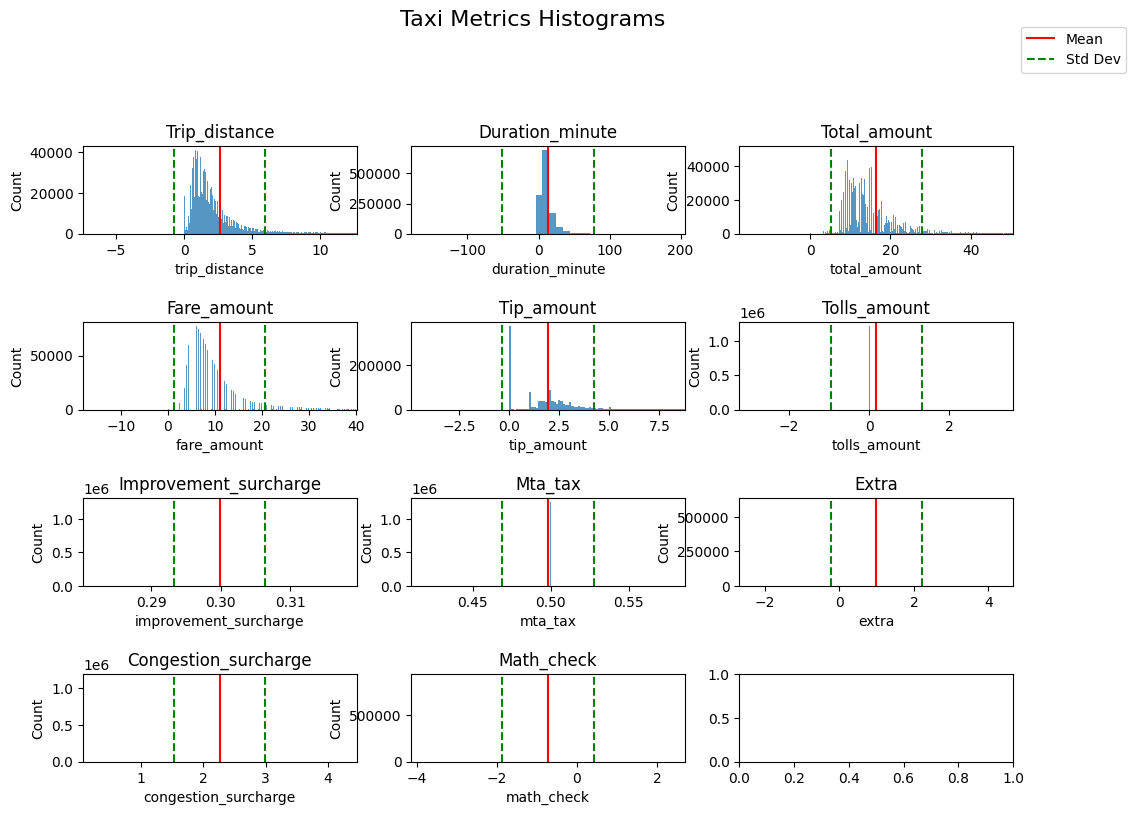

In [51]:
fig, axs = plt.subplots(4, 3, figsize=(12, 8))

for i, column in enumerate(numeric_cols):
    taxi_var = taxi_df_clean[column]
    mean = taxi_var.mean()
    std_dev = taxi_var.std()
    
    row = i // 3
    col = i % 3
    
    sns.histplot(taxi_var, bins=3000, ax=axs[row, col])
    axs[row, col].set_title(column.capitalize())
    
    # Set x-axis limits based on min and max values in the column
    axs[row, col].set_xlim(mean - 3*std_dev, mean + 3*std_dev)
    
    axs[row, col].axvline(taxi_var.mean(), color='red', label='Mean')
    axs[row, col].axvline(taxi_var.mean() - taxi_var.std(), color='green', linestyle='--', label='Std Dev')
    axs[row, col].axvline(taxi_var.mean() + taxi_var.std(), color='green', linestyle='--')

# Add a single legend for all four plots
handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, bbox_to_anchor=(1, 1), loc='right', ncol=1)

# Add a title for the whole figure
fig.suptitle('Taxi Metrics Histograms', fontsize=16, y=1.05)

# Add some padding between the subplots
plt.subplots_adjust(hspace=1)

# display the plot
plt.show()

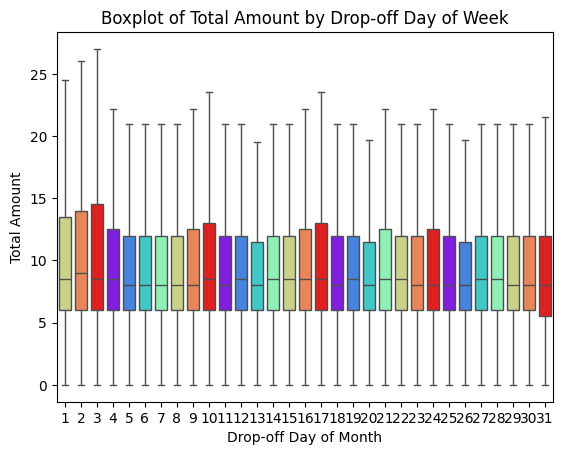

In [52]:
sns.boxplot(x='drop_off_day', y='fare_amount', data=taxi_df_clean, hue='drop_off_dow', palette='rainbow', showfliers=False, legend=False)
plt.xlabel('Drop-off Day of Month')
plt.ylabel('Total Amount')
plt.title('Boxplot of Total Amount by Drop-off Day of Week')
plt.show()

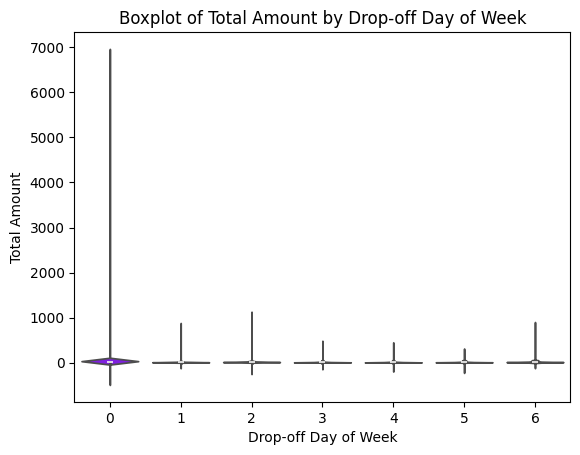

In [53]:
sns.violinplot(x='drop_off_dow', y='fare_amount', data=taxi_df, hue='drop_off_dow', palette='rainbow', legend=False)
plt.xlabel('Drop-off Day of Week')
plt.ylabel('Total Amount')
plt.title('Boxplot of Total Amount by Drop-off Day of Week')
plt.show()